# SQL on BigQuery

```
SELECT limit_balance, sex, education_level, marital_status, age, 
       pay_0, pay_2, pay_3, pay_4, pay_5, pay_6, 
       bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6, 
       pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6,
       default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 37981
```

# 1 - Perkenalan
  > Bab pengenalan harus diisi dengan identitas, gambaran besar dataset yang digunakan, dan _objective_ yang ingin dicapai.

## 1 - Identity

  Nama : Jason Rich Darmawan Onggo Putra
  
  Batch : 016 RMT

## 2 - Dataset Overview

## 3 - Objective

  > Buatlah model Classification untuk memprediksi default_payment_next_month menggunakan dataset yang sudah kalian simpan.

  Choose an algorithm with default parameters that have the best metrics. Then, improve the algorithm with tuned parameters.

  The algorithm should have metircs:
  1. accuracy score of 0.8
  2. recall score of 0.9 for class 1
  3. precision score of 0.9 for class 1
  4. f1 score of 0.9 for class 1.

# 2 - Import Libraries
  > _Cell_ pertama pada _notebook_ **harus berisi dan hanya berisi** semua _library_ yang digunakan dalam _project_.

In [84]:
# Model Tuning causes UserWarning due to
# the train set never see the category
# then was asked to predict the validation set.
import os, sys, warnings
# if not sys.warnoptions:
#     warnings.simplefilter("ignore")
#     os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

# Data Loading
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats

# Data Preprocessing
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Model Definition
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score, \
f1_score, accuracy_score
from sklearn.exceptions import ConvergenceWarning

# Model Tuning
from sklearn.model_selection import GridSearchCV

# Model Saving
import joblib

# 3 - Data Loading
  > Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut. Proses Data Loading dapat berupa memberi nama baru untuk setiap kolom, mengecek ukuran dataset, dll.

In [85]:
# Load Dataset
data_set = pd.read_csv("./h8dsft_P1M1_jason_rich_darmawan_onggo_putra.csv")

## 1 - Columns Data Types

In [86]:
# head and tail
data_set

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,50000,1,3,0,50,0,0,0,-1,-1,...,3400,2769,0,2266,0,3400,2769,1700,0,0
1,200000,2,3,0,45,-2,-2,-2,-2,-2,...,399,1396,0,2430,0,399,1396,0,0,0
2,130000,1,1,1,45,0,0,0,0,0,...,62377,63832,65099,2886,2908,2129,2354,2366,2291,0
3,230000,1,2,1,41,0,0,0,0,0,...,216260,215968,174195,9405,7769,7757,8030,6549,5226,1
4,50000,1,2,1,42,0,0,0,0,0,...,31320,36227,35569,2007,2000,1500,5400,0,3000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,320000,1,2,1,41,1,-2,-2,-2,-2,...,0,700,860,0,0,0,700,860,2420,1
2961,20000,1,1,1,39,-1,-1,-1,-1,-1,...,630,664,598,700,600,700,700,600,1400,0
2962,20000,1,2,2,25,0,0,0,0,0,...,16600,17025,17381,1300,1300,1300,700,630,650,0
2963,50000,1,2,2,38,0,0,0,0,0,...,17833,18246,18642,1300,1600,650,700,700,700,0


## 2 - Columns Dtypes

- no missing values
- [x] change columns dtypes to 'object': 'sex', 'education_level', 'marital_status', 'default_payment_next_month'
- [x] change columns dtypes to 'category': 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6' [outline](#41---what-are-pay_0-bill_amt_1-pay_amt_1)

- numerical data: 
  - 'limit_balance', 'age'
  - 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6'
  - 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'
- nominal data: 
  - 'sex'
  - 'education_level'
    
    description:
    > Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
  - 'marital_status'
    
    description:
    > Marital status (1=married, 2=single, 3=others)
- ordinal data: 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6' [outline](#41---what-are-pay_0-bill_amt_1-pay_amt_1)

Rules for pandas dtypes:
1. ordinal use 'category' dtypes.
2. nominal use 'object' dtypes.
3. numerical use 'number' dtypes.
4. target use 'category' dtypes. due to issue with sklearn.

In [87]:
# find the columns dtypes
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   limit_balance               2965 non-null   int64
 1   sex                         2965 non-null   int64
 2   education_level             2965 non-null   int64
 3   marital_status              2965 non-null   int64
 4   age                         2965 non-null   int64
 5   pay_0                       2965 non-null   int64
 6   pay_2                       2965 non-null   int64
 7   pay_3                       2965 non-null   int64
 8   pay_4                       2965 non-null   int64
 9   pay_5                       2965 non-null   int64
 10  pay_6                       2965 non-null   int64
 11  bill_amt_1                  2965 non-null   int64
 12  bill_amt_2                  2965 non-null   int64
 13  bill_amt_3                  2965 non-null   int64
 14  bill_amt

In [88]:
# change nominal data dtypes to object
data_set[['sex', 'education_level', 'marital_status']] = \
    data_set[['sex', 'education_level', 'marital_status']].astype('object')

In [89]:
type_pay0_pay6 = pd.api.types.CategoricalDtype(categories=[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])

# change ordinal data dtypes to category
data_set[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']] = \
    data_set[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].astype(type_pay0_pay6)

type_default_payment_next_month = pd.api.types.CategoricalDtype(categories=[0, 1])
data_set['default_payment_next_month'] = \
    data_set['default_payment_next_month'].astype(type_default_payment_next_month)

In [90]:
# get the columns
numerical_columns = data_set.select_dtypes(include='number').columns.to_numpy()
ordinal_columns = data_set.drop('default_payment_next_month', axis='columns').select_dtypes(include='category').columns.to_numpy()
nominal_columns = data_set.select_dtypes(include='object').columns.to_numpy()

## 3 - Central Tendency

- [x] why is 'bill_amt_2' have minus values. [outline](#42---relationship-between-x-numerical-and-y-categorical)
- [x] why is 'bill_amt_2' have high maximum values. [outline](#42---relationship-between-x-numerical-and-y-categorical)

In [91]:
# bill_amt_1 to bill_amt_6 have minus.
with pd.option_context("display.float_format", '{:,.0f}'.format):
    display(data_set.describe(include='number'))

,limit_balance,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
count,"2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965"
mean,"163,369",35,"52,118","50,649","48,240","44,090","40,956","39,773","6,349","6,272","5,150","4,561","4,913","5,383"
std,"125,030",9,"72,329","70,785","68,146","61,907","58,272","57,303","20,886","28,880","14,287","13,281","16,734","17,276"
min,"10,000",21,"-11,545","-67,526","-25,443","-46,627","-46,627","-73,895",0,0,0,0,0,0
25%,"50,000",28,"3,958","3,390","3,302","2,582","1,958","1,430","1,013",990,477,313,323,173
50%,"140,000",34,"24,257","23,111","21,520","19,894","18,814","18,508","2,234","2,175","1,994","1,600","1,646","1,615"
75%,"230,000",41,"69,852","67,827","63,023","58,622","53,373","52,287","5,087","5,000","4,500","4,000","4,021","4,081"
max,"800,000",69,"613,860","512,650","578,971","488,808","441,981","436,172","493,358","1,227,082","199,209","202,076","388,071","403,500"


In [92]:
# get the mode and cardinality
data_set.describe(include=['object','category'])

,sex,education_level,marital_status,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,default_payment_next_month
count,2965,2965,2965,2965,2965,2965,2965,2965,2965,2965
unique,2,7,4,11,10,9,10,9,8,2
top,2,2,2,0,0,0,0,0,0,0
freq,1802,1400,1594,1516,1607,1610,1667,1702,1626,2330


In [93]:
data_set['education_level'].value_counts()

2    1400
1    1039
3     483
5      24
4      13
6       4
0       2
Name: education_level, dtype: int64

# 4 - Exploratory Data Analysis (EDA)
  > Bagian ini berisi eksplorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana, dan lain sebagainya.

  Task:
  1. Insights

## 4.1 - what are 'pay_2', 'bill_amt_2', 'pay_amt_1'

- [x] why 'pay_0' have value '-2'

  EDA shows there are '-2'.

  > [-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608)

- [x] is 'bill_amt_2' paid in 'pay_amt_1'?

  EDA shows there are a handful of people that paid in 'pay_amt_1' based on 'bill_amt_2'. Therefore, we assume that 'bill_amt_2' is billing statement of the month and paid 'pay_amt_1' in the next month.

  > [Billing statements are issued monthly at the end of each billing cycle.](https://www.investopedia.com/terms/b/billing-statement.asp)

description:
- 'pay_0' 
  > Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)

- 'pay_2'
  > Repayment status in August, 2005 (scale same as above)

- 'bill_amt_1'
  > Amount of bill statement in September, 2005 (NT dollar)

- 'bill_amt_2'
  > Amount of bill statement in August, 2005 (NT dollar)

- 'pay_amt_1'
  > Amount of previous payment in September, 2005 (NT dollar)

- 'pay_amt_2' 
  > Amount of previous payment in August, 2005 (NT dollar)

magic sentence: 'bill_amt_6' is paid by 'pay_amt_5' and affected the status 'pay_5'

In [94]:
# is bill_amt_2 paid in pay_amt_1 ?
# yes.
data_set.loc[(data_set['bill_amt_2'] == data_set['pay_amt_1']),
             ['pay_0', 'pay_2', 'pay_3',
              'bill_amt_1', 'bill_amt_2', 'bill_amt_3',
              'pay_amt_1', 'pay_amt_2', 'pay_amt_3']][:10]

,pay_0,pay_2,pay_3,bill_amt_1,bill_amt_2,bill_amt_3,pay_amt_1,pay_amt_2,pay_amt_3
1,-2,-2,-2,399,2430,0,2430,0,399
335,0,0,-2,2960,0,0,0,0,0
361,0,0,-2,22908,32513,6192,32513,9,8
434,2,2,-2,15304,0,0,0,0,0
441,1,-2,-1,0,0,9311,0,9311,1257
444,1,-2,-1,0,0,1900,0,1900,7411
448,1,-2,-1,0,0,3000,0,3000,1800
449,-2,-2,-2,390,0,1151,0,1151,10312
450,1,-2,-2,0,0,0,0,0,1054
451,1,-2,-1,0,0,369,0,369,55


### 1 - Are there any errors?

We are going to drop 32% of data due to errors. Either our errors handling strategy is wrong. Or the dataset is full of errors.

- [x] drops error from the train set
  > [Theoretically, 25 to 30% is the maximum missing values are allowed, beyond which we might want to drop the variable from analysis.](https://discuss.analyticsvidhya.com/t/what-should-be-the-allowed-percentage-of-missing-values/2456)

  Alright. We are going to drop it from the train set.

- [x] fill '0' to '3' from 'marital_status'
-

In [95]:
errors_drop_miscalculation_index = []

# errors detected
def isolate():
    global errors_drop_miscalculation_index
    for columns in [
        ['bill_amt_4', 'bill_amt_5', 'pay_amt_4'],
        ['bill_amt_3', 'bill_amt_4', 'pay_amt_3'],
        ['bill_amt_2', 'bill_amt_3', 'pay_amt_2'],
        ['bill_amt_1', 'bill_amt_2', 'pay_amt_1']
    ]:
        # find errors
        # if a person overpay 'bill_amt_5' with 'pay_amt_4'
        # the 'bill_amt_4' should not be smaller than 'bill_amt_5' - 'pay_amt_4'
        errors = data_set.loc[
            ((data_set[columns[1]] - data_set[columns[2]]) < 0)
            & (data_set[columns[0]] < (data_set[columns[1]] - data_set[columns[2]]))
            , columns]
        display(errors)

        # drop
        errors_drop_miscalculation_index += errors.index.tolist()

isolate()

errors_drop_miscalculation_index = list(set(errors_drop_miscalculation_index))
print("errors to drop length", len(errors_drop_miscalculation_index))

,bill_amt_4,bill_amt_5,pay_amt_4


,bill_amt_3,bill_amt_4,pay_amt_3
1138,-202,1201,1302


,bill_amt_2,bill_amt_3,pay_amt_2
2052,-6,-3,0


,bill_amt_1,bill_amt_2,pay_amt_1
2029,-330,340,500
2332,-22,-11,0


errors to drop length 4


In [96]:
# customer paid in full, yet marked as 0 = using revolving credit
data_set.iloc[31:32][['pay_4', 'bill_amt_5', 'pay_amt_4', 'pay_5', 'bill_amt_6', 'pay_amt_5']]

,pay_4,bill_amt_5,pay_amt_4,pay_5,bill_amt_6,pay_amt_5
31,0,11790,11790,0,12045,430


In [97]:
errors_drop_mislabel_duly_paid_index = []

# 'bill_amt_6' is paid by 'pay_amt_5' and affected the status 'pay_5'
def isolate():
    global errors_drop_mislabel_duly_paid_index
    for columns in [
        ['pay_5', 'bill_amt_6', 'pay_amt_5'],
        ['pay_4', 'bill_amt_5', 'pay_amt_4'],
        ['pay_3', 'bill_amt_4', 'pay_amt_3'],
        ['pay_2', 'bill_amt_3', 'pay_amt_2'],
        ['pay_0', 'bill_amt_2', 'pay_amt_1']
    ]:
        # if 'pay_5' is 0
        # therefore, 'bill_amt_6' should be not equal 'pay_amt_5'
        errors = data_set.loc[
            (data_set[columns[0]] == 0)
            & (data_set[columns[1]] == data_set[columns[2]])
            , columns]
        # display(errors)

        errors_drop_mislabel_duly_paid_index += errors.index.tolist()
        
isolate()

errors_drop_mislabel_duly_paid_index = list(set(errors_drop_mislabel_duly_paid_index))
print("errors to drop length", len(errors_drop_mislabel_duly_paid_index))

errors to drop length 337


In [98]:
errors_drop_mislabel_no_consumption_index = []

def isolate():
    global errors_drop_mislabel_no_consumption_index
    # global errors_replace_to_duly_paid_index
    for columns in [
        # we can't be sure because we don't have 'bill_amt_7' column to compare
        # ['bill_amt_5', 'pay_5', 'bill_amt_6', 'pay_amt_5']

        ['pay_4', 'bill_amt_5', 'pay_amt_4', 'bill_amt_6'],
        ['pay_3', 'bill_amt_4', 'pay_amt_3', 'bill_amt_5'],
        ['pay_2', 'bill_amt_3', 'pay_amt_2', 'bill_amt_4'],
        ['pay_0', 'bill_amt_2', 'pay_amt_1', 'bill_amt_3']
    ]:
        # if 'pay_4' == -2
        # then 'bill_amt_5' should be equal to 'bill_amt_6'
        # or 'bill_amt_5' should not be larger than 'bill_amt_6' - 'pay_amt_5'
        errors = data_set.loc[
            (data_set[columns[0]] == -2)
            & ( (data_set[columns[1]] != data_set[columns[3]])
              | (data_set[columns[1]] <= (data_set[columns[3]] - data_set[columns[1]])))
            , columns]
        # display(errors)

        errors_drop_mislabel_no_consumption_index += errors.index.tolist()

isolate()

errors_drop_mislabel_no_consumption_index = list(set(errors_drop_mislabel_no_consumption_index))
print("errors to drop length", len(errors_drop_mislabel_no_consumption_index))

errors to drop length 498


In [99]:
# we are going to drop 32% of data due to errors
# either our errors handling strategy is wrong
# or the dataset is full of errors
# but if the logic behind erros handling strategy is acceptable
# therefore, the only strategy is to drop it because
# we can't guess of the actual value.
# get the dataset.shape
data_set.shape

(2965, 24)

In [100]:
# from the dataset source, there is no value 0
# we will drop it.
data_set['marital_status'].value_counts()

2    1594
1    1332
3      35
0       4
Name: marital_status, dtype: int64

In [101]:
data_set['education_level'].value_counts()

2    1400
1    1039
3     483
5      24
4      13
6       4
0       2
Name: education_level, dtype: int64

## 4.2 - Relationship between X Numerical and y Categorical

'limit balance':
1. person with 'default_payment_next_month' '1' have lower limit balance.

'age':
1. no difference between person with 'default_payment_next_month' '1' in age.

'bill_amt_1' to 'bill_amt_6':
1. the outliers are worrying.
2. the outliers are natural outliers.
   
   This assumption is based on people that have 'bill_amt_2' > 164482.5, does not pay in full 'pay_amt_1' but is still labeled as 'pay_2' 0.
3. maybe there are errors.
   - [x] check if 'bill_amt_1' and so on are larger than 'limit_balance'
     
     We can't determine a data as errors using this method.

'bill_amt_2':
1. person with minus bill is more likely with 'default_payment_next_month' '0'
2. however, people that overpay still

'pay_amt_1' to 'pay_amt_6':
1. the outliers are worrying
2. the outliers are natural outliers.
3. even if the outliers are errors. we can't detect it because people can overpay.

- [x] use `sklearn.preprocessing.RobustScaler` for every numerical data.

  - because every columns have outliers.
  - using `sklearn.preprocessing.MinMaxScaler` is unwise because it will reduce the outliers weight.

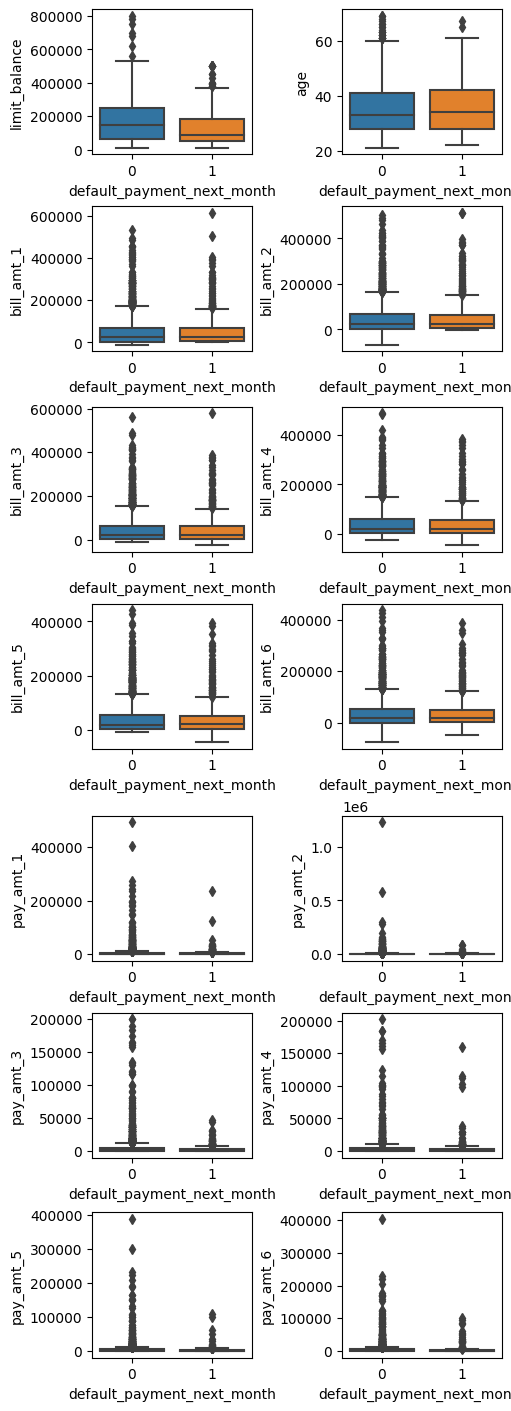

In [102]:
# prevent global variable
def isolate():
    fig, axes = plt.subplots(nrows=7, ncols=2, constrained_layout=True, figsize=(5,14))
    for column, ax in zip(numerical_columns, axes.ravel()):
        sns.boxplot(data=data_set, x="default_payment_next_month", y=column, ax=ax)

isolate()

In [103]:
# get skew of numerical columns
# every numerical columns are moderately or highly skewed to the right
# use RobustScaler!
def isolate():
    display(data_set[numerical_columns].skew())
isolate()

limit_balance     1.000442
age               0.772887
bill_amt_1        2.484598
bill_amt_2        2.458349
bill_amt_3        2.569937
bill_amt_4        2.448175
bill_amt_5        2.400343
bill_amt_6        2.432406
pay_amt_1        11.877647
pay_amt_2        29.404261
pay_amt_3         8.044639
pay_amt_4         8.451541
pay_amt_5        11.468890
pay_amt_6         9.760184
dtype: float64

In [104]:
# prevent global variable
# get the lower fence and upper fence
def isolate():
    q1, q3 = data_set['bill_amt_2'].quantile([.25, .75])
    iqr = q3 - q1
    print(q1 - 1.5*iqr, q3 + 1.5*iqr)

isolate()

-93265.5 164482.5


In [105]:
# check the value of 'pay_2' of person with 'bill_amt_2' > 120k
# 'bill_amt_2' does not need to be paid in full.
data_set.loc[data_set['bill_amt_2'] > 164482.5, ['pay_2', 'bill_amt_2', 'pay_amt_1']][:10]

,pay_2,bill_amt_2,pay_amt_1
3,0,305327,9405
9,0,195970,7822
10,0,167378,54209
12,0,173440,8083
13,0,171565,20000
14,0,176294,5519
16,0,254078,9251
28,0,177644,6100
29,0,295998,13200
33,0,169969,8450


In [106]:
# check errors
# we can't assume that if bill > limit_balance as errors.
# this is because limit_balance does not give us information about
# the current limit_balance of every month.
data_set.loc[(data_set['limit_balance'] < data_set['bill_amt_1']) |
            (data_set['limit_balance'] < data_set['bill_amt_2']) |
            (data_set['limit_balance'] < data_set['bill_amt_3']) |
            (data_set['limit_balance'] < data_set['bill_amt_4']) |
            (data_set['limit_balance'] < data_set['bill_amt_5']) |
            (data_set['limit_balance'] < data_set['bill_amt_6']), 
            ['limit_balance', 'bill_amt_1', 'bill_amt_2', 'bill_amt_4', 'bill_amt_5',
             'bill_amt_6']]

,limit_balance,bill_amt_1,bill_amt_2,bill_amt_4,bill_amt_5,bill_amt_6
3,230000,301038,305327,216260,215968,174195
5,140000,132541,136186,140962,137819,137094
7,130000,130067,129385,98071,97743,100124
19,50000,48875,50103,31459,28901,29523
31,70000,136809,118811,53696,11790,12045
...,...,...,...,...,...,...
2936,50000,51132,49594,48532,27308,27539
2937,60000,60521,61450,28853,29510,26547
2938,30000,28854,30467,28961,29397,29988
2939,80000,77760,79248,60989,41023,42663


In [107]:
# index 446 'bill_amt_2' have minus values with 'pay_2' -2 and pay_amt_1 0
# this indicates that minus values in 'bill_amt_2' as overpayment.
data_set.loc[(data_set['bill_amt_2'] < 0), ['pay_2', 'bill_amt_2', 'pay_amt_1']][:10]

,pay_2,bill_amt_2,pay_amt_1
446,-2,-420,0
447,-2,-5,0
455,-2,-1935,10000
456,-2,-694,0
459,-2,-31,0
465,-2,-316,0
471,-2,-58,0
476,-2,-3,0
480,-2,-4,0
489,-2,-2,0


## 3 - Relationship X Categorical and y Categorical

no nominal columns that can indicate a person will default.

ordinal columns 'pay_6' to 'pay_0' are good separator of instance with 'default_payment_next_month' '1'. A person is more likely to defaulted after delaying payments for 2 months. 

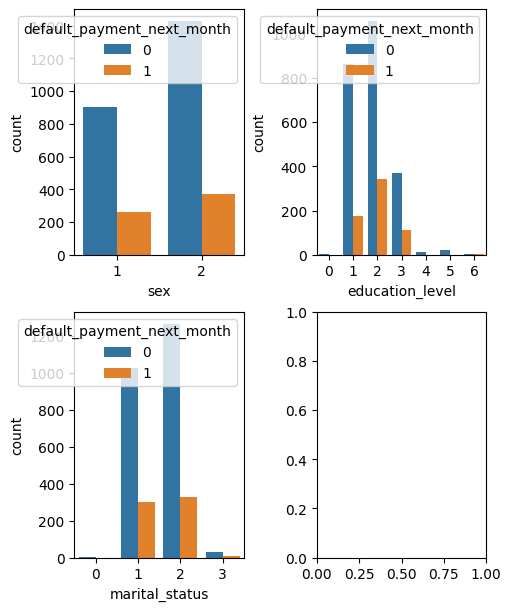

In [108]:
# prevent global variable
def isolate():
    fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(5,6))
    for column, ax in zip(nominal_columns, axes.ravel()):
        sns.countplot(data=data_set, x=column, hue="default_payment_next_month", ax=ax)
        
isolate()

<AxesSubplot: xlabel='education_level', ylabel='count'>

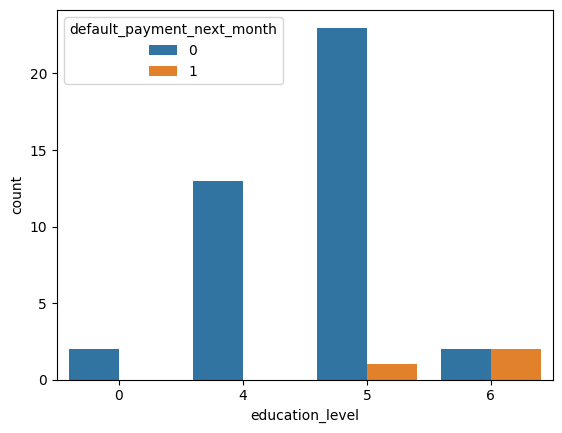

In [109]:
# double check education_level
# education_level=6 or unknown is more likely to default 
# compared to other education_level
# However, the frequency is too small.
sns.countplot(data=data_set[~data_set['education_level'].isin([1,2,3])], 
              x="education_level", hue="default_payment_next_month")

<AxesSubplot: xlabel='marital_status', ylabel='count'>

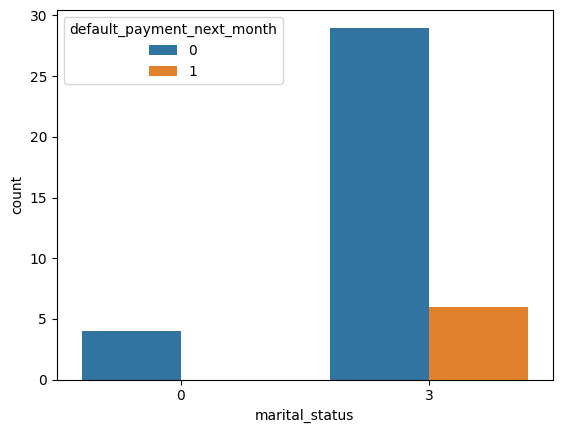

In [110]:
# marital_status is not a good separator of default_payment_next_month.
sns.countplot(data=data_set[data_set['marital_status'].isin(values=[0, 3])], 
              x="marital_status", hue="default_payment_next_month")

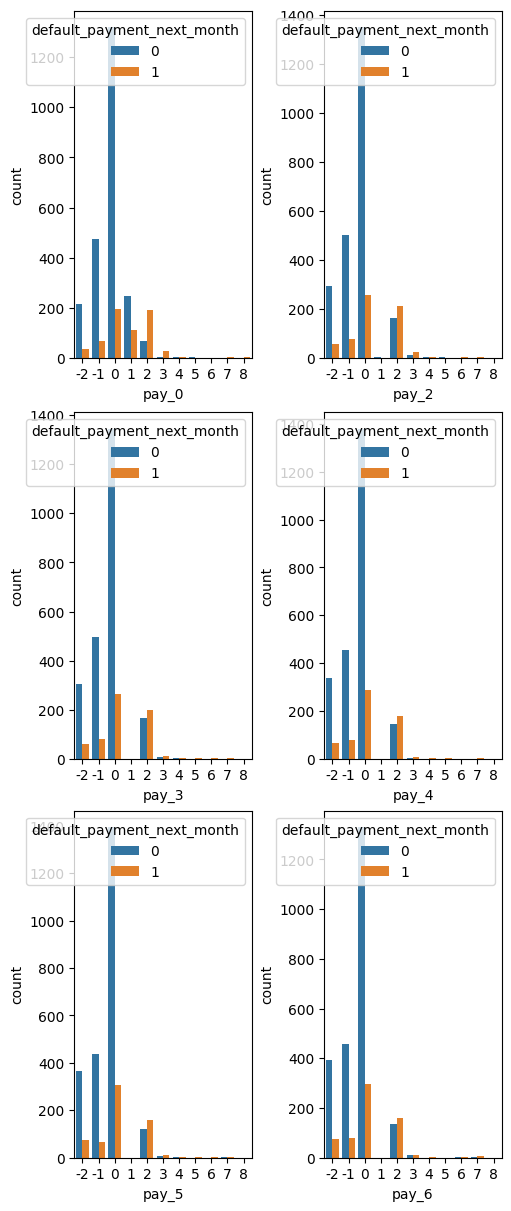

In [111]:
# prevent global variable
# people are more likely to default next month after delaying payment for 2 months
def isolate():
    fig, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True, figsize=(5,12))
    for column, ax in zip(ordinal_columns, axes.ravel()):
        sns.countplot(data=data_set, x=column, hue="default_payment_next_month", ax=ax)

isolate()

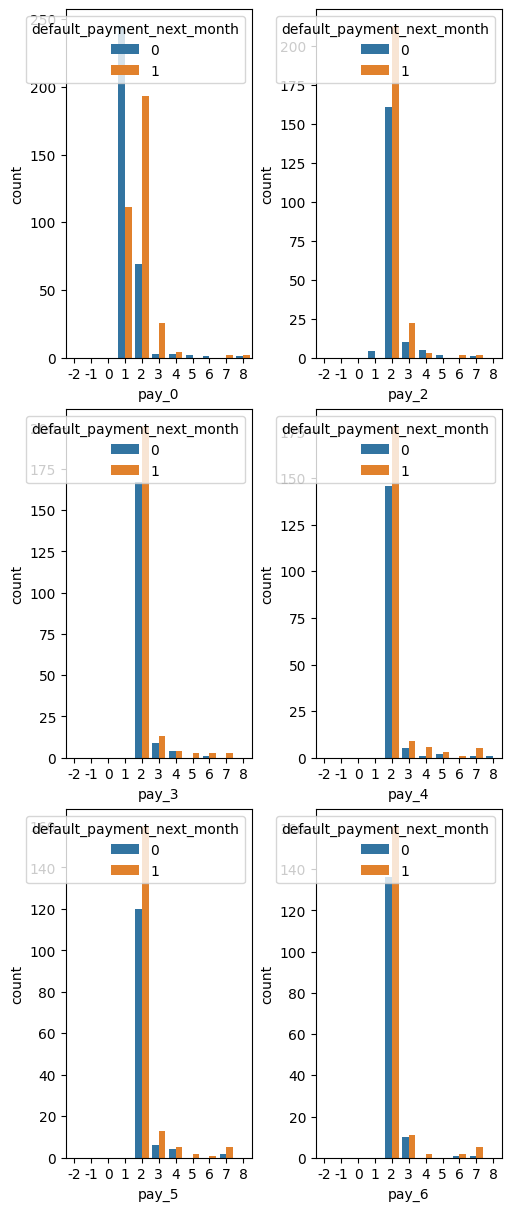

In [112]:
# double check if 'pay_0' to 'pay_6' with value 1 is more likely to default_payment_next_month '1'
# we can see that, if a person delayed payment for 2 months, the more likely that the person to default_payment_next_month '1'

# prevent global variable
def isolate():
    fig, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True, figsize=(5,12))
    for column, ax in zip(ordinal_columns, axes.ravel()):
        sns.countplot(data=data_set[data_set[column].cat.codes > 2], x=column, hue="default_payment_next_month", ax=ax)

isolate()

In [113]:
# prevent global variable:
# index 3 the person was paying with payment plan ('pay_6' to 'pay_0' value are always 0)
# however, the next month that person defaulted.
# therefore, we can't drop any of the columns
def isolate():
    columns = np.concatenate([ordinal_columns, numerical_columns[2:]], axis=0)
    display(data_set.loc[data_set['default_payment_next_month'] == 1, columns])

isolate()

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
3,0,0,0,0,0,0,301038,305327,213058,216260,215968,174195,9405,7769,7757,8030,6549,5226
6,0,0,0,0,0,0,13561,14573,15290,16300,16624,16974,1543,1260,1270,594,617,1425
8,2,0,0,0,0,2,63426,57922,55010,52540,56236,40922,2700,2500,1900,4600,0,1600
30,0,0,0,0,0,0,3769,4782,5797,6654,6786,7077,1239,1254,1111,243,400,252
33,0,0,0,0,0,0,165686,169969,170142,119529,122059,111378,8450,5289,4022,4195,3986,3958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2955,2,2,2,0,0,0,17497,18219,17629,18036,18446,18840,1300,0,700,700,700,800
2956,1,2,0,0,0,0,17614,17042,18052,18562,18814,19500,0,1300,810,700,1000,900
2958,3,2,2,2,3,3,6269,7212,7246,8073,8349,8420,1200,300,1100,700,500,0
2959,1,-2,-2,-2,-1,-1,-200,-200,-200,0,700,1935,0,0,200,700,1935,0


## 4.2 - Imbalance Dataset

[reference](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data)

The dataset is imbalanced. The dataset set is have high variations as well.

Therefore, do not do under sampling to avoid losing information.

- [x] do over sampling

In [114]:
# check if the dataset is imbalanced.
data_set['default_payment_next_month'].value_counts()

0    2330
1     635
Name: default_payment_next_month, dtype: int64

In [115]:
# check if high variations
# out of 2964 rows, only 1 is duplicated.
data_set.value_counts()

limit_balance  sex  education_level  marital_status  age  pay_0  pay_2  pay_3  pay_4  pay_5  pay_6  bill_amt_1  bill_amt_2  bill_amt_3  bill_amt_4  bill_amt_5  bill_amt_6  pay_amt_1  pay_amt_2  pay_amt_3  pay_amt_4  pay_amt_5  pay_amt_6  default_payment_next_month
200000         2    1                1               34   1      -2     -2     -2     -2     -2     0            0          0           0           0           0           0          0          0          0          0          0          0                             2
10000          1    1                2               23   2      2      2      2      -2     -1     2724         5520       5275        0           0           150         3000       0          0          0          150        275        0                             1
200000         2    1                2               40   2      2      0      0      0      2      185696       181236     185410      189069      197736      183299      0          8600       8

# 5 - Data Preprocessing
  > Bagian ini berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi train-dev-test, transformasi data (normalisasi, encoding, dll.), dan proses-proses lain yang dibutuhkan.

In [116]:
# Split dataset to Inference Set
inference_set = data_set.groupby(by='default_payment_next_month') \
                        .sample(5, random_state=17)

In [117]:
# Remove Inference Set from dataset
data_train_test = data_set.drop(inference_set.index)

In [118]:
# Split dataset to X and y
X = data_train_test.drop(['default_payment_next_month'], axis=1)
y = data_train_test['default_payment_next_month']

In [119]:
print("X", X.shape, "y", y.shape)

X (2955, 23) y (2955,)


In [120]:
# Split dataset to Train Set and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=17,
                                                    stratify=y)

print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_test", X_test.shape, "y_test", y_test.shape)

X_train (2364, 23) y_train (2364,)
X_test (591, 23) y_test (591,)


## Handling Errors

In [121]:
# drop errors that can't be saved from train set
X_train.drop(index=X_train.filter(items=errors_drop_miscalculation_index, axis=0).index, 
             inplace=True)
y_train.drop(index=y_train.filter(items=errors_drop_miscalculation_index, axis=0).index, 
             inplace=True)

X_train.drop(index=X_train.filter(items=errors_drop_mislabel_duly_paid_index, axis=0).index,
             inplace=True)
y_train.drop(index=y_train.filter(items=errors_drop_mislabel_duly_paid_index, axis=0).index, 
             inplace=True)

X_train.drop(index=X_train.filter(items=errors_drop_mislabel_no_consumption_index, axis=0).index,
             inplace=True)
y_train.drop(index=y_train.filter(items=errors_drop_mislabel_no_consumption_index, axis=0).index,
             inplace=True)

In [122]:
# '0' to '3' in 'marital_status'
# '5', '6', '0' to '4' in 'education_level'
def isolate():
    education_level = (data_set['education_level'] == 5) | (data_set['education_level'] == 6) \
                      | (data_set['education_level'] == 0)
    X_train.loc[education_level, 'education_level'] = 4

    marital_status = (data_set['marital_status'] == 0)
    X_train.loc[marital_status, 'marital_status'] = 3

isolate()

In [123]:
# check if rows are equal
X_train.shape, y_train.shape

((1749, 23), (1749,))

In [124]:
# check the imbalance
y_train.value_counts()

0    1342
1     407
Name: default_payment_next_month, dtype: int64

## 1 - Pipeline

Pipeline to handle outliers, missing values, do feature engineering (scaling, encoding).

In [125]:
# feature scaling
numerical_transformer = Pipeline(
    steps=[
        # the numerical columns have natural outliers.
        ('imputer', SimpleImputer(strategy="median")),
        # the numerical columns are moderately to highly skewed to the right.
        ('scaler', RobustScaler())
    ]
)

# feature encoding
ordinal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('encoder', OrdinalEncoder(categories=[
                                    type_pay0_pay6.categories,
                                    type_pay0_pay6.categories,
                                    type_pay0_pay6.categories,
                                    type_pay0_pay6.categories,
                                    type_pay0_pay6.categories,
                                    type_pay0_pay6.categories],
                                   handle_unknown='use_encoded_value',
                                   # because pay0_pay6 uses 0
                                   unknown_value=np.nan))
        # do not scale ordinal.
    ]
)

nominal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")),
        # drop='first' to avoid multicollinearity
        # handle_unknown='ignore' to handle the model with never seen data
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

transformers = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numerical_columns),
        ("ordinal", ordinal_transformer, ordinal_columns),
        ("nominal", nominal_transformer, nominal_columns)
    ],
)

ros = RandomOverSampler(sampling_strategy=1, random_state=17)

# preprocessor for end-to-end
# WARNING: make sure to use `imblearn.pipeline` instead of `sklearn.pipeline`
# to avoid data leakage when cross validation
preprocessor = Pipeline(
    steps=[
        ('columntransformer', transformers),
        ('randomoversampler', ros),
    ]
)

## 2 - Multicollinearity

- [x] use data that have been preprocessed.

- [x] drop columns 'bill_amt_6', 'bill_amt_2', 'bill_amt_4', 'bill_amt_3'
- [x] drop columns 'pay_5', 'pay_2'
- [x] drop column 'education_level'

In [126]:
def getXy_train_res_final():
    X_train_res_final, y_train_res_final = preprocessor.fit_resample(X=X_train, y=y_train)
    
    Xy_train_res_final = \
      np.concatenate([X_train_res_final, 
                      y_train_res_final.to_numpy().reshape(-1,1)], axis=1)

    Xy_train_res_final_df = pd.DataFrame(data=Xy_train_res_final, 
                                         columns=np.concatenate([
                                            preprocessor.get_feature_names_out(),
                                            ["default_payment_next_month"]
                                         ]))
    return Xy_train_res_final_df

In [127]:
# VIF tells you a different story.
# VIF is used to identify the correlation of one independent numerical feature
# with a group of other numerical features. 
def isolate():
    global numerical_columns_selected
    numerical_columns_selected = \
        numerical_columns[np.where(~np.in1d(numerical_columns, 
                                            ['bill_amt_6', 'bill_amt_2',
                                             'bill_amt_4', 'bill_amt_3']))]

    Xy_train_res_final = getXy_train_res_final()
    
    df_columns = ["numerical__" + column for column in numerical_columns_selected]

    vif_data = pd.DataFrame(data={
        "Feature": df_columns,
        "VIF": [variance_inflation_factor(Xy_train_res_final[df_columns], i)
                for i in range(len(df_columns))]
    })
    
    display(vif_data.style.background_gradient(cmap="coolwarm"))

isolate()

,Feature,VIF
0,numerical__limit_balance,1.501880
1,numerical__age,1.029651
2,numerical__bill_amt_1,4.557889
3,numerical__bill_amt_5,4.838375
4,numerical__pay_amt_1,1.519495
5,numerical__pay_amt_2,1.471456
6,numerical__pay_amt_3,1.341874
7,numerical__pay_amt_4,1.149463
8,numerical__pay_amt_5,1.103457
9,numerical__pay_amt_6,1.123468


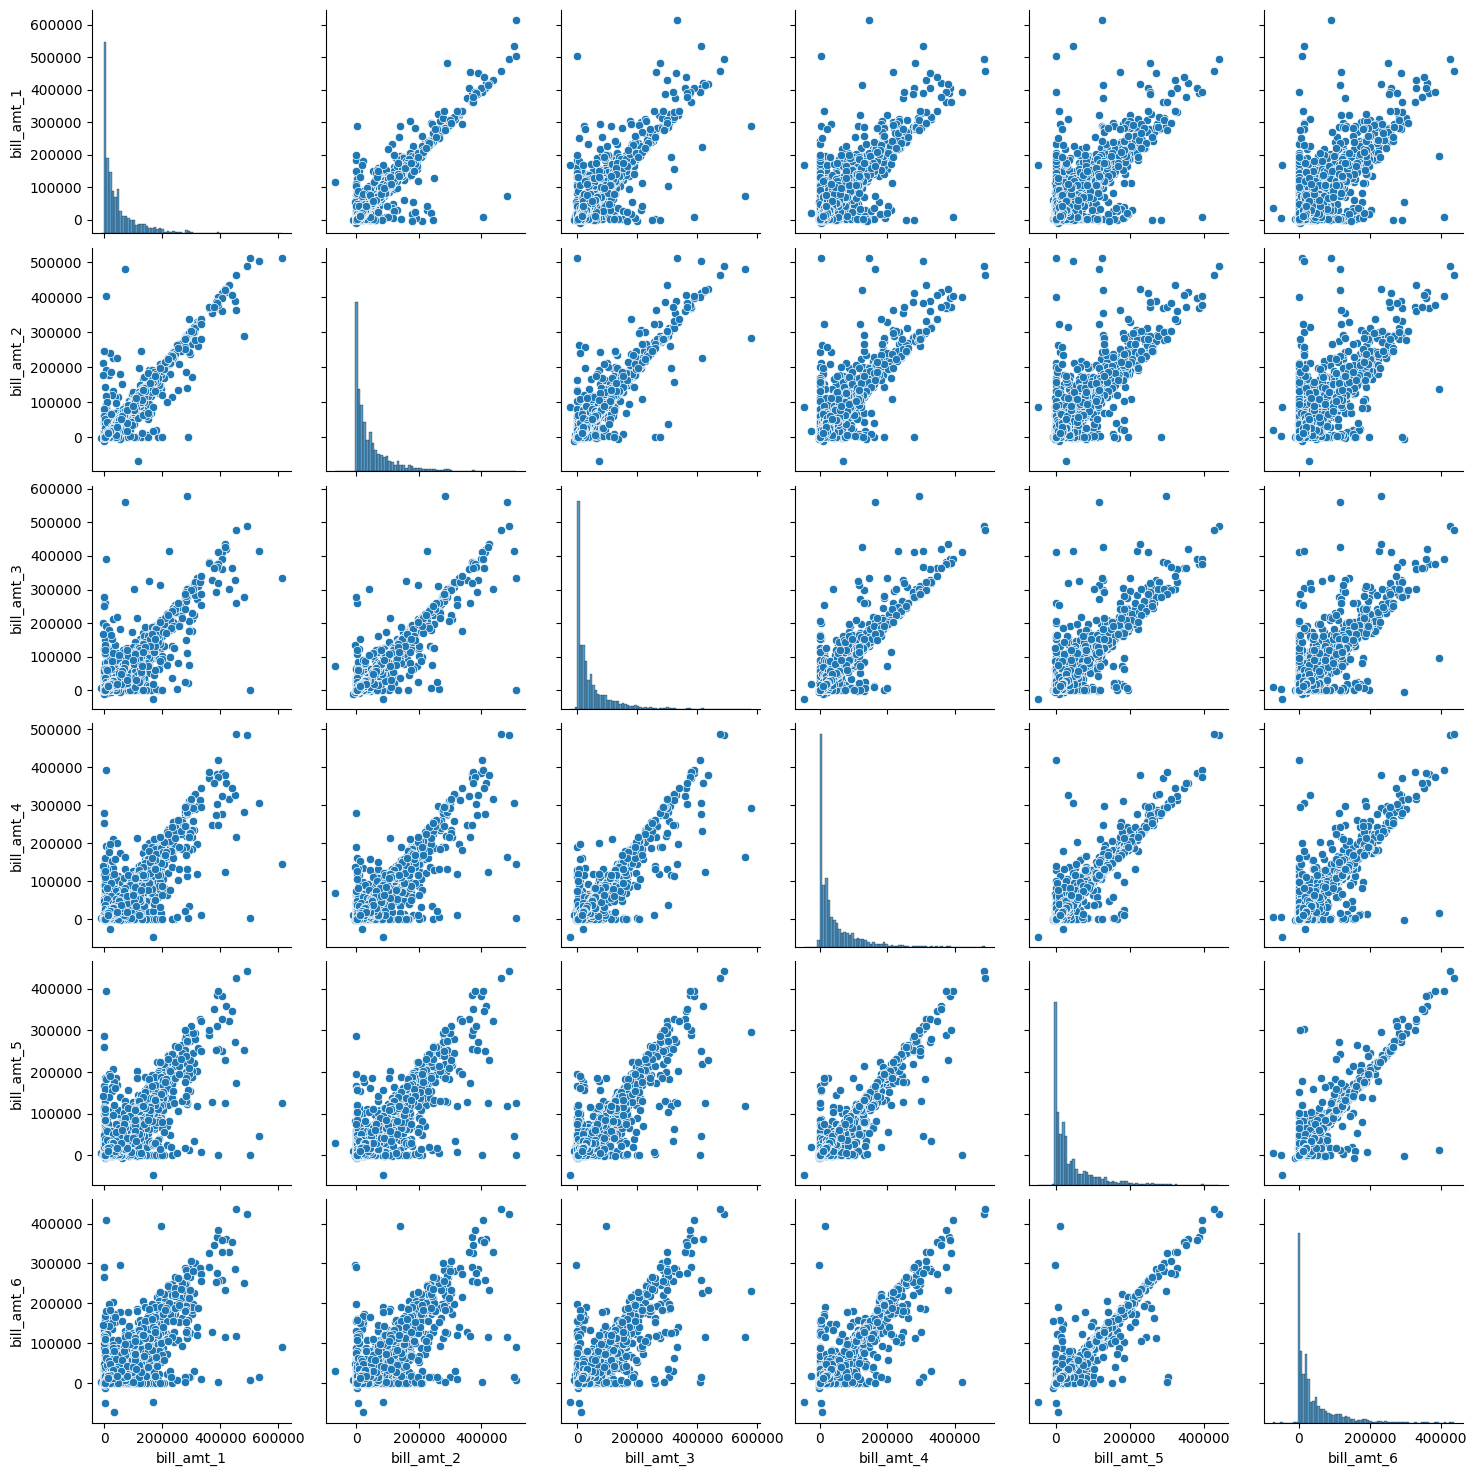

In [128]:
# check linear or non linear
# this is a must because there are linear and nonlinear bivariate relationship
# this is because pearson is not the right choice for non linear
# our focus is 'bill_amt_1' to 'bill_amt_6'
def isolate():
    g = sns.pairplot(data=data_set[['bill_amt_1', 'bill_amt_2',
                                    'bill_amt_3', 'bill_amt_4',
                                    'bill_amt_5', 'bill_amt_6']])
    g.fig.set_size_inches(15,15)

isolate()

In [129]:
# check multicollinearity with pearson for numerical.
def isolate():
    # change numerical_columns to columns to see the effect
    global numerical_columns_selected
    numerical_columns_selected = \
        numerical_columns[np.where(~np.in1d(numerical_columns, 
                                            ['bill_amt_3', 'bill_amt_4',
                                             'bill_amt_2', 'bill_amt_5',
                                             'bill_amt_6']))]

    Xy_train_res_final_df = getXy_train_res_final()
    
    df_columns = np.concatenate([
        ["numerical__" + column for column in numerical_columns_selected],
        ["default_payment_next_month"]
    ])

    display(Xy_train_res_final_df[df_columns].corr(method="pearson")
                                             .style.background_gradient(cmap='coolwarm'))

isolate()

,numerical__limit_balance,numerical__age,numerical__bill_amt_1,numerical__pay_amt_1,numerical__pay_amt_2,numerical__pay_amt_3,numerical__pay_amt_4,numerical__pay_amt_5,numerical__pay_amt_6,default_payment_next_month
numerical__limit_balance,1.000000,0.089221,0.446761,0.205097,0.174888,0.312000,0.219808,0.250226,0.237018,-0.233572
numerical__age,0.089221,1.000000,0.070434,0.031489,0.000423,0.033389,0.066948,0.026303,0.006153,0.006545
numerical__bill_amt_1,0.446761,0.070434,1.000000,0.103444,0.077928,0.135551,0.203376,0.159215,0.172585,-0.026512
numerical__pay_amt_1,0.205097,0.031489,0.103444,1.000000,0.511393,0.308847,0.083891,0.092661,0.127385,-0.096553
numerical__pay_amt_2,0.174888,0.000423,0.077928,0.511393,1.000000,0.341709,0.056019,0.062385,0.117872,-0.080599
numerical__pay_amt_3,0.312000,0.033389,0.135551,0.308847,0.341709,1.000000,0.105056,0.137825,0.191805,-0.137923
numerical__pay_amt_4,0.219808,0.066948,0.203376,0.083891,0.056019,0.105056,1.000000,0.084673,0.102483,-0.027334
numerical__pay_amt_5,0.250226,0.026303,0.159215,0.092661,0.062385,0.137825,0.084673,1.000000,0.121954,-0.091879
numerical__pay_amt_6,0.237018,0.006153,0.172585,0.127385,0.117872,0.191805,0.102483,0.121954,1.000000,-0.110894
default_payment_next_month,-0.233572,0.006545,-0.026512,-0.096553,-0.080599,-0.137923,-0.027334,-0.091879,-0.110894,1.000000


In [130]:
# check multicollinearity with spearman for ordinal
# prevent global variable
# drop 'pay_5', 'pay_2'
def isolate():
    # columns do not contains column 'pay_5'
    global ordinal_columns_selected
    ordinal_columns_selected = \
        ordinal_columns[np.where(~np.in1d(ordinal_columns, ['pay_6', 'pay_4',
                                                            'pay_5', 'pay_3']))]

    Xy_train_res_final = getXy_train_res_final()

    df_columns = np.concatenate([
        ["ordinal__" + column for column in ordinal_columns_selected],
        ["default_payment_next_month"]
    ], axis=0)

    display(Xy_train_res_final[df_columns].corr(method="spearman")
                                          .style.background_gradient(cmap="coolwarm"))

isolate()

,ordinal__pay_0,ordinal__pay_2,default_payment_next_month
ordinal__pay_0,1.000000,0.723636,0.454919
ordinal__pay_2,0.723636,1.000000,0.354958
default_payment_next_month,0.454919,0.354958,1.000000


In [131]:
# reference: https://passel2.unl.edu/view/lesson/9beaa382bf7e/8#:~:text=If%20your%20chi%2Dsquare%20calculated,to%20reject%22%20your%20null%20hypothesis.
# p < 0.05 : education level - marital status observed deviations are significant.
# chi-square > critical value : reject null hypothesis. 
# alternative hypohesis: there are relationship between 'education_level' and 'marital_status'

def isolate():
    global nominal_columns_selected
    nominal_columns_selected = \
        nominal_columns[np.where(~np.in1d(nominal_columns, ['education_level']))]

    X_train_res_final, _ = ros.fit_resample(X=X_train, y=y_train)

    for i in range(len(nominal_columns_selected)):
        for j in range(len(nominal_columns_selected)):
            if i == j or i > j:
                continue
            
            print(f'{nominal_columns_selected[i]} - {nominal_columns_selected[j]}')
            
            chi2, p, dof, _ =  \
                scipy.stats.chi2_contingency(
                    observed=pd.crosstab(X_train_res_final[nominal_columns_selected[i]], 
                                         X_train_res_final[nominal_columns_selected[j]]))

            critical = scipy.stats.chi2.ppf(q=0.95, df=dof)
            print(f'chi2: {chi2:.2f} {chi2 > critical}; p: {p:.2f} {p < 0.05}; dof: {dof};')
isolate()

sex - marital_status
chi2: 0.53 False; p: 0.77 False; dof: 2;


## 3 - Pipeline (After Feature Selection)

Pipeline to handle outliers, missing values, do feature engineering (scaling, encoding).

In [132]:
# feature encoding
# 'education_level' is dropped
nominal_transformer_v2 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")),
        # drop='first' to avoid multicollinearity
        # handle_unknown='ignore' to handle the model with never seen data
        ('encoder', OneHotEncoder(drop='first',
                                  categories=[
                                    [1,2],
                                    [1,2,3]
                                  ],
                                  handle_unknown='ignore'))
    ]
)

# 'pay_5', 'pay_2' is dropped, so we have to remove it from the pipeline.
ordinal_transformer_v2 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('encoder', OrdinalEncoder(categories=[
                                    type_pay0_pay6.categories,
                                    type_pay0_pay6.categories
                                   ],
                                   handle_unknown='use_encoded_value',
                                   # because pay0_pay6 uses 0
                                   unknown_value=np.nan))
        # do not scale ordinal.
    ]
)

## 4 - Preprocessor

In [133]:
# column transformer
transformers_v2 = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numerical_columns_selected),
        ("ordinal", ordinal_transformer_v2, ordinal_columns_selected),
        ("nominal", nominal_transformer_v2, nominal_columns_selected)
    ],
)

# preprocessor for end-to-end
# WARNING: make sure to use `imblearn.pipeline` instead of `sklearn.pipeline`
# to avoid data leakage when cross validation
preprocessor_v2 = Pipeline(
    steps=[
        ('randomoversampler', ros),
        ('columntransformer', transformers_v2),
    ]
)

# 6 - Model Definition
  > Bagian ini berisi cell untuk mendefinisikan model. Jelaskan alasan menggunakan suatu algoritma/model, hyperparameter yang dipakai, jenis penggunaan metrics yang dipakai, dan hal lain yang terkait dengan model.

## 1 - Logistic Regression

In [134]:
# logistic regression pipeline
log_reg_default = make_pipeline(*preprocessor_v2, LogisticRegression(penalty="l2", C=1.0))

## 2 - SVM

In [135]:
# support vector machine pipeline
svm_default = make_pipeline(*preprocessor_v2, SVC(C=1.0, kernel='rbf', gamma='scale'))

## 3 - Decision Tree

In [136]:
# decision tree pipeline
tree_clf_default = make_pipeline(*preprocessor_v2, 
                                 DecisionTreeClassifier(criterion="gini", 
                                                        max_depth=None, 
                                                        min_samples_leaf=1,
                                                        random_state=17,
                                                        max_features=None))

## 4 - KNN

In [137]:
# KNearestNeighbors pipeline
knn_default = make_pipeline(*preprocessor_v2, KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2))

## 5 - Naive Bayes

The assumption is a feature do not affect the other feature.

In [138]:
# NaiveBayes pipeline
nb_default = make_pipeline(*preprocessor_v2, GaussianNB())

## 6 - Random Forest

In [139]:
rf_clf_default = make_pipeline(*preprocessor_v2, 
                               RandomForestClassifier(n_estimators=100, 
                                                      criterion="gini", 
                                                      max_depth=None, 
                                                      min_samples_leaf=1,
                                                      random_state=17))

# 7 - Model Training
  > Cell pada bagian ini hanya berisi code untuk melatih model dan output yang dihasilkan. Lakukan beberapa kali proses training dengan hyperparameter yang berbeda untuk melihat hasil yang didapatkan. Analisis dan narasikan hasil ini pada bagian Model Evaluation.

## 1 - Default Parameter

### 1 - Logistic Regression

In [140]:
# training the algorithm with default parameter
log_reg_default.fit(X=X_train, y=y_train)

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=17, sampling_strategy=1)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  array(['limit_balance', 'age', 'bill_amt_1', 'pay_amt_1', 'pay_amt_2',
       'pay_amt_3', 'pay_amt_4', 'pay_amt_5',...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  array(['pay_0', 'pay_2'], dtype=object)),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(categories=[[1,
                                                                                              2],
                                                                                             [1,
                                                                                              2,
                                                                                              3]],
                                                                                 drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['sex', 'marital_status'], dtype=object))])),
                ('logisticregression', LogisticRegression())])

### 2 - SVM

In [141]:
# training the algorithm with default parameter
svm_default.fit(X=X_train, y=y_train)

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=17, sampling_strategy=1)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  array(['limit_balance', 'age', 'bill_amt_1', 'pay_amt_1', 'pay_amt_2',
       'pay_amt_3', 'pay_amt_4', 'pay_amt_5',...
                                                                                              Int64Index([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  array(['pay_0', 'pay_2'], dtype=object)),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(categories=[[1,
                                                                                              2],
                                                                                             [1,
                                                                                              2,
                                                                                              3]],
                                                                                 drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['sex', 'marital_status'], dtype=object))])),
                ('svc', SVC())])

### 3 - Decision Tree

In [142]:
# training the algorithm with default parameter
tree_clf_default.fit(X=X_train, y=y_train)

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=17, sampling_strategy=1)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  array(['limit_balance', 'age', 'bill_amt_1', 'pay_amt_1', 'pay_amt_2',
       'pay_amt_3', 'pay_amt_4', 'pay_amt_5',...
                                                                                  unknown_value=nan))]),
                                                  array(['pay_0', 'pay_2'], dtype=object)),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(categories=[[1,
                                                                                              2],
                                                                                             [1,
                                                                                              2,
                                                                                              3]],
                                                                                 drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['sex', 'marital_status'], dtype=object))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=17))])

### 4 - KNN

In [143]:
# training the algorithm with default parameter
knn_default.fit(X=X_train, y=y_train)

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=17, sampling_strategy=1)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  array(['limit_balance', 'age', 'bill_amt_1', 'pay_amt_1', 'pay_amt_2',
       'pay_amt_3', 'pay_amt_4', 'pay_amt_5',...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  array(['pay_0', 'pay_2'], dtype=object)),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(categories=[[1,
                                                                                              2],
                                                                                             [1,
                                                                                              2,
                                                                                              3]],
                                                                                 drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['sex', 'marital_status'], dtype=object))])),
                ('kneighborsclassifier', KNeighborsClassifier())])

### 5 - Naive Bayes

In [144]:
# training the algorithm with default parameter
nb_default.fit(X=X_train, y=y_train)

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=17, sampling_strategy=1)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  array(['limit_balance', 'age', 'bill_amt_1', 'pay_amt_1', 'pay_amt_2',
       'pay_amt_3', 'pay_amt_4', 'pay_amt_5',...
                                                                                              Int64Index([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  array(['pay_0', 'pay_2'], dtype=object)),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(categories=[[1,
                                                                                              2],
                                                                                             [1,
                                                                                              2,
                                                                                              3]],
                                                                                 drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['sex', 'marital_status'], dtype=object))])),
                ('gaussiannb', GaussianNB())])

### 6 - Random Forest

In [145]:
# Training the algorithm with default parameters
rf_clf_default.fit(X=X_train, y=y_train)

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=17, sampling_strategy=1)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  array(['limit_balance', 'age', 'bill_amt_1', 'pay_amt_1', 'pay_amt_2',
       'pay_amt_3', 'pay_amt_4', 'pay_amt_5',...
                                                                                  unknown_value=nan))]),
                                                  array(['pay_0', 'pay_2'], dtype=object)),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(categories=[[1,
                                                                                              2],
                                                                                             [1,
                                                                                              2,
                                                                                              3]],
                                                                                 drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['sex', 'marital_status'], dtype=object))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=17))])

## 2 - Model Tuning

  Goal: To find the best parameters for the algorithm.

  We are going to use `sklearn.model_selection.GridSearchCV` (based on best algorithm with default parameters)

  Task: 
  1. compare the metrics between algorithm with default parameters and best parameters.

  Although, SVM f1 score (train and test set) are better. We believe Random Forest have more room for improvement due to its ability to overfit with default parameter. We just need to do pruning.

  Therefore, algorithm with the best cross validate result is [Random Forest](#8116---random-forest).

### Ask Instructor

- [ ] How to use `sklearn.model_selection.GridSearchCV` to find the best score based on:
  - First filter: the least difference between train and test set metrics. 
  - Then, consider the highest metrics based on the first filter.
  - The current solution is only choose the highest metrics.

In [146]:
scoring = {
    'recall': make_scorer(score_func=recall_score, pos_label=1),
    'precision': make_scorer(score_func=precision_score, pos_label=1, zero_division=0),
    'f1': make_scorer(score_func=f1_score, pos_label=1),
    'accuracy_score': make_scorer(score_func=accuracy_score)
}
           
def GridSearchCV_display(cv_results: dict):
    cv_results_df = pd.DataFrame(cv_results)
    cv_results_df['diff_mean_recall'] = cv_results_df['mean_test_recall'] - cv_results_df['mean_train_recall']
    cv_results_df['diff_mean_precision'] = cv_results_df['mean_test_precision'] - cv_results_df['mean_train_precision']
    cv_results_df['diff_mean_f1'] = cv_results_df['mean_test_f1'] - cv_results_df['mean_train_f1']
    cv_results_df['diff_mean_accuracy_score'] = cv_results_df['mean_test_accuracy_score'] - cv_results_df['mean_train_accuracy_score']

    with pd.option_context('display.max_colwidth', None, "display.float_format", "{:.3f}".format):
        display(cv_results_df[[
            'params', 
            'mean_test_recall', 'diff_mean_recall',
            'mean_test_precision', 'diff_mean_precision',
            'mean_test_f1', 'diff_mean_f1',
            'mean_test_accuracy_score', 'diff_mean_accuracy_score']]
                .sort_values(by=['mean_test_recall', 'diff_mean_recall'], ascending=False).T)

### 1 - Random Forest

[refence](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/)

First attempt:
1. 'max_depth': 1 to 10.
   - The test set stops increasing after max_depth 7.

In [147]:
# default parameters
rf_clf_default.named_steps['randomforestclassifier'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [148]:
# get max_samples per bootstrap for random forest
getXy_train_res_final().shape[0]

2684

In [149]:
# get how many features
rf_clf_default[:-1].get_feature_names_out()

array(['numerical__limit_balance', 'numerical__age',
       'numerical__bill_amt_1', 'numerical__pay_amt_1',
       'numerical__pay_amt_2', 'numerical__pay_amt_3',
       'numerical__pay_amt_4', 'numerical__pay_amt_5',
       'numerical__pay_amt_6', 'ordinal__pay_0', 'ordinal__pay_2',
       'nominal__sex_2', 'nominal__marital_status_2',
       'nominal__marital_status_3'], dtype=object)

#### 1 - 'max_depth' 1 to 20

The test set f1 score stops increasing after 'max_depth' 7. This indicates that the Random Forest starts to overfit the training set.

'best params'

{'randomforestclassifier__max_depth': 7}

best test f1 score 0.5985815835448031


<AxesSubplot: >

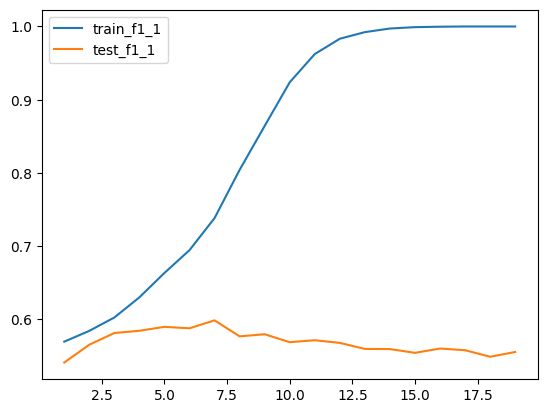

In [150]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     scoring=scoring,
                     refit="f1",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': np.arange(start=1,stop=20,step=1),
                     },
                     n_jobs=-1)

# ignore OneHotEncoder warning about unkonwn categories
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=UserWarning)
    rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test f1 score", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_depth'], 
             y=rf_cv.cv_results_['mean_train_f1'], label="train_f1_1")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_depth'],
             y=rf_cv.cv_results_['mean_test_f1'], label="test_f1_1")


#### 2 - 'min_samples_split' 2 to 2000

The test f1 score stops increasing after 'min_samples_split' 40. This indicates that the Random Forest starts to overfit the training set.

We can see that with 'min_samples_split' below 100, we have significant difference between the train and test f1 score.

'min_samples_split' above 1300, we have significant drop in both train and test set.

'best params'

{'randomforestclassifier__max_depth': 7,
 'randomforestclassifier__min_samples_split': 2}

best test f1 score 0.5985815835448031


<AxesSubplot: >

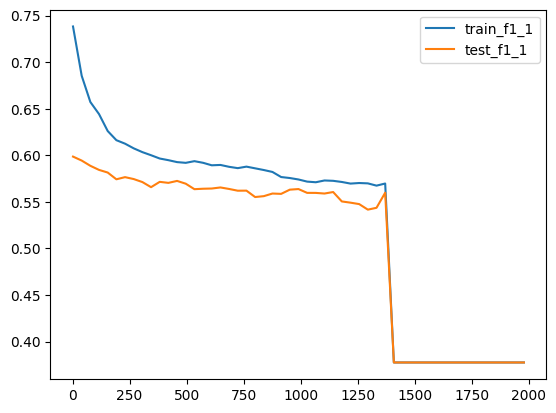

In [151]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     scoring=scoring,
                     refit="f1",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': [7],
                        'randomforestclassifier__min_samples_split': np.arange(start=2,stop=2000,step=38),
                     },
                     n_jobs=-1)

# ignore OneHotEncoder warning about unkonwn categories
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=UserWarning)
    rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test f1 score", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__min_samples_split'], 
             y=rf_cv.cv_results_['mean_train_f1'], 
             label="train_f1_1")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__min_samples_split'],
             y=rf_cv.cv_results_['mean_test_f1'], 
             label="test_f1_1")

#### 3 - 'max_leaf_nodes' 2 to 100

If the value of the 'max_leaf_nodes' below 10, it will underfit.

The test set f1 score stops increasing after 'max_leaf_nodes' 52.

'best params'

{'randomforestclassifier__max_depth': 7,
 'randomforestclassifier__max_leaf_nodes': 32,
 'randomforestclassifier__min_samples_split': 2}

best test f1 score 0.5953300619349225


<AxesSubplot: >

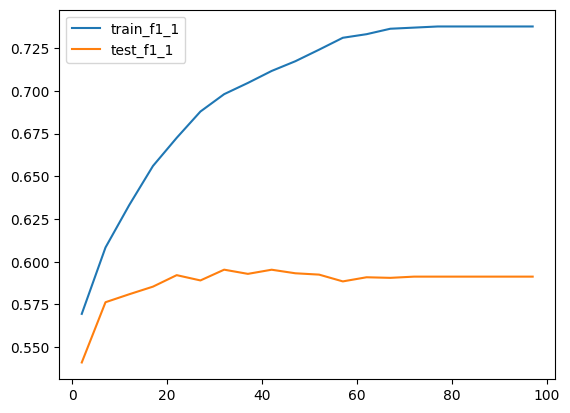

In [152]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     scoring=scoring,
                     refit="f1",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': [7],
                        'randomforestclassifier__min_samples_split': [2],
                        'randomforestclassifier__max_leaf_nodes': np.arange(start=2, stop=100, step=5),
                     },
                     n_jobs=-1)

# ignore OneHotEncoder warning about unkonwn categories
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=UserWarning)
    rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test f1 score", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_leaf_nodes'], 
             y=rf_cv.cv_results_['mean_train_f1'], 
             label="train_f1_1")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_leaf_nodes'],
             y=rf_cv.cv_results_['mean_test_f1'], 
             label="test_f1_1")

#### 4 - 'min_samples_leaf' 1 to 800

The model is overfitting when 'min_samples_leaf' below < 5.

The test set f1 score stops increasing after 'min_samples_leaf' 11.

'best params'

{'randomforestclassifier__max_depth': 7,
 'randomforestclassifier__max_leaf_nodes': 32,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2}

best test f1 score 0.5953300619349225


<AxesSubplot: >

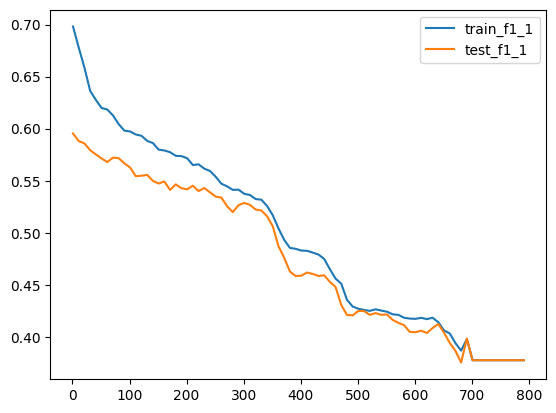

In [153]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     scoring=scoring,
                     refit="f1",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': [7],
                        'randomforestclassifier__min_samples_split': [2],
                        'randomforestclassifier__max_leaf_nodes': [32],
                        'randomforestclassifier__min_samples_leaf': np.arange(start=1, stop=800, step=10),
                     },
                     n_jobs=-1)

# ignore OneHotEncoder warning about unkonwn categories
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=UserWarning)
    rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test f1 score", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__min_samples_leaf'], 
             y=rf_cv.cv_results_['mean_train_f1'], 
             label="train_f1_1")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__min_samples_leaf'],
             y=rf_cv.cv_results_['mean_test_f1'], 
             label="test_f1_1")

#### 5 - 'n_estimators' 1 to 600

'n_estimators' 1 equals to 1 Decision Tree Classifier. Therefore, large number of estimators will have large computational cost.

The test f1 score stops increasing after 'n_estimators' 50.

'best params'

{'randomforestclassifier__max_depth': 7,
 'randomforestclassifier__max_leaf_nodes': 32,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 90}

best test f1 score 0.5982500180736211


<AxesSubplot: >

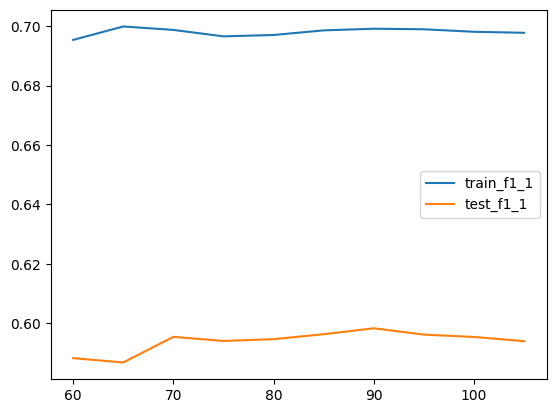

In [154]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     # what the user care is the model ability to find class 1.
                     # but if the precision is low, it will cause miss opportunity
                     # for the bank to loan money
                     scoring=scoring,
                     refit="f1",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': [7],
                        'randomforestclassifier__min_samples_split': [2],
                        'randomforestclassifier__max_leaf_nodes': [32],
                        'randomforestclassifier__min_samples_leaf': [1],
                        'randomforestclassifier__n_estimators': np.arange(start=60, stop=110, step=5),
                     },
                     n_jobs=-1)

# ignore OneHotEncoder warning about unkonwn categories
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=UserWarning)
    rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test f1 score", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__n_estimators'], 
             y=rf_cv.cv_results_['mean_train_f1'], 
             label="train_f1_1")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__n_estimators'],
             y=rf_cv.cv_results_['mean_test_f1'], 
             label="test_f1_1")

#### 7 - 'max_samples' 0.1 to 1

> If float, then draw max_samples * X.shape[0] samples. Thus, max_samples should be in the interval (0.0, 1.0].

The test f1 score stops increasing after 'max_samples' 0.1

In [155]:
# get the max samples per bootstrap
getXy_train_res_final().shape

(2684, 27)

'best params'

{'randomforestclassifier__max_depth': 7,
 'randomforestclassifier__max_leaf_nodes': 32,
 'randomforestclassifier__max_samples': 1.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 100}

best test f1 score 0.5953300619349225


<AxesSubplot: >

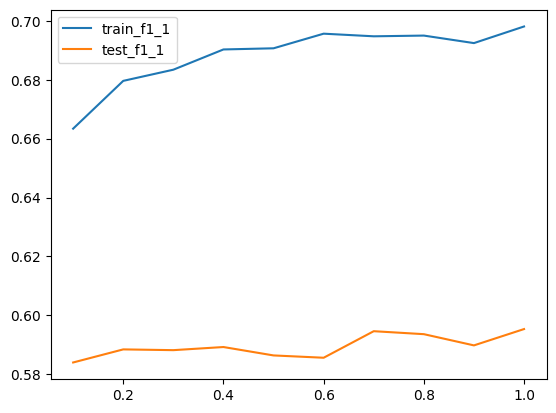

In [156]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     # what the user care is the model ability to find class 1.
                     # but if the precision is low, it will cause miss opportunity
                     # for the bank to loan money
                     scoring=scoring,
                     refit="f1",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': [7],
                        'randomforestclassifier__min_samples_split': [2],
                        'randomforestclassifier__max_leaf_nodes': [32],
                        'randomforestclassifier__min_samples_leaf': [1],
                        'randomforestclassifier__n_estimators': [100],
                        'randomforestclassifier__max_samples': np.arange(start=0.1, stop=1.1, step=0.1),
                     },
                     n_jobs=-1)

# ignore OneHotEncoder warning about unkonwn categories
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=UserWarning)
    rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test f1 score", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_samples'], 
             y=rf_cv.cv_results_['mean_train_f1'], 
             label="train_f1_1")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_samples'],
             y=rf_cv.cv_results_['mean_test_f1'], 
             label="test_f1_1")

#### 8 - 'max_features' 1 to 16

The test f1 score stops increasing after 'max_features' 2.

In [157]:
# get how many features we have
rf_clf_default.n_features_in_

26

In [158]:
# get available features
rf_clf_default[:-1].get_feature_names_out()

array(['numerical__limit_balance', 'numerical__age',
       'numerical__bill_amt_1', 'numerical__pay_amt_1',
       'numerical__pay_amt_2', 'numerical__pay_amt_3',
       'numerical__pay_amt_4', 'numerical__pay_amt_5',
       'numerical__pay_amt_6', 'ordinal__pay_0', 'ordinal__pay_2',
       'nominal__sex_2', 'nominal__marital_status_2',
       'nominal__marital_status_3'], dtype=object)

'best params'

{'randomforestclassifier__max_depth': 7,
 'randomforestclassifier__max_features': 3,
 'randomforestclassifier__max_leaf_nodes': 32,
 'randomforestclassifier__max_samples': 1.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 100}

best test f1 score 0.5953300619349225


<AxesSubplot: >

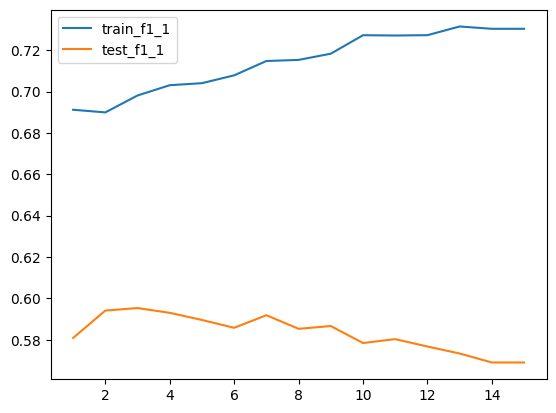

In [159]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     # what the user care is the model ability to find class 1.
                     # but if the precision is low, it will cause miss opportunity
                     # for the bank to loan money
                     scoring=scoring,
                     refit="f1",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': [7],
                        'randomforestclassifier__min_samples_split': [2],
                        'randomforestclassifier__max_leaf_nodes': [32],
                        'randomforestclassifier__min_samples_leaf': [1],
                        'randomforestclassifier__n_estimators': [100],
                        'randomforestclassifier__max_samples': [1.0],
                        'randomforestclassifier__max_features': np.arange(start=1,stop=16,step=1),
                     },
                     n_jobs=-1)

# ignore OneHotEncoder warning about unkonwn categories
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=UserWarning)
    rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test f1 score", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_features'], 
             y=rf_cv.cv_results_['mean_train_f1'], 
             label="train_f1_1")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_features'],
             y=rf_cv.cv_results_['mean_test_f1'], 
             label="test_f1_1")

#### 9 - GridSearchCV

In [160]:
np.arange(start=20, stop=25, step=2)

array([20, 22, 24])

'best params'

{'randomforestclassifier__max_depth': 8,
 'randomforestclassifier__max_features': 3,
 'randomforestclassifier__max_leaf_nodes': 31,
 'randomforestclassifier__max_samples': 1.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 99}

best test f1 score 0.6006470264271734


<AxesSubplot: >

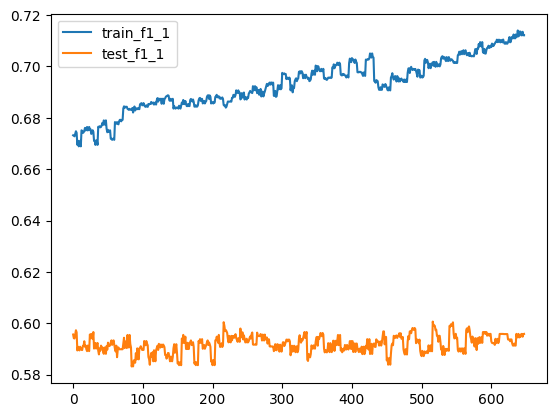

In [161]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     # what the user care is the model ability to find class 1.
                     # but if the precision is low, it will cause miss opportunity
                     # for the bank to loan money
                     scoring=scoring,
                     refit="f1",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': [6,7,8],
                        'randomforestclassifier__min_samples_split': [2,3],
                        'randomforestclassifier__max_leaf_nodes': [31,32,33],
                        'randomforestclassifier__min_samples_leaf': [1,2],
                        'randomforestclassifier__n_estimators': [99,100,101],
                        'randomforestclassifier__max_samples': [0.9,1.0],
                        'randomforestclassifier__max_features': [2,3,4],
                     },
                     n_jobs=-1)

# ignore OneHotEncoder warning about unkonwn categories
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=UserWarning)
    rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test f1 score", rf_cv.best_score_)
# GridSearchCV_display(rf_cv.cv_results_)

sns.lineplot(x=np.arange(start=0, stop=len(rf_cv.cv_results_['mean_train_f1']), step=1), 
             y=rf_cv.cv_results_['mean_train_f1'], 
             label="train_f1_1")
sns.lineplot(x=np.arange(start=0, stop=len(rf_cv.cv_results_['mean_train_f1']), step=1),
             y=rf_cv.cv_results_['mean_test_f1'], 
             label="test_f1_1")

In [179]:
# define the model
rf_clf_tuned = make_pipeline(*preprocessor_v2, 
                             RandomForestClassifier(
                                random_state=17,
                                max_depth=8,
                                max_features=3,
                                max_leaf_nodes=31,
                                max_samples=1.0,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                n_estimators=99
                             ))

In [180]:
# Train the algorithm with tuned parameters
rf_clf_tuned.fit(X=X_train, y=y_train)

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=17, sampling_strategy=1)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  array(['limit_balance', 'age', 'bill_amt_1', 'pay_amt_1', 'pay_amt_2',
       'pay_amt_3', 'pay_amt_4', 'pay_amt_5',...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(categories=[[1,
                                                                                              2],
                                                                                             [1,
                                                                                              2,
                                                                                              3]],
                                                                                 drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['sex', 'marital_status'], dtype=object))])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=8, max_features=3,
                                        max_leaf_nodes=31, max_samples=1.0,
                                        n_estimators=99, random_state=17))])

# 8 - Model Evaluation
  > Pada bagian ini, dilakukan evaluasi model yang harus menunjukkan bagaimana performa model berdasarkan metrics yang dipilih. Hal ini harus dibuktikan dengan visualisasi tren performa dan/atau tingkat kesalahan model. **Lakukan analisis terkait dengan hasil pada model dan tuliskan hasil analisisnya**.

Goal: To validate if the metrics aree consistent and not due to data leakage.

Metrics used are: `sklearn.metrics.precision_score`, `sklearn.metrics.recall_score`, `sklearn.metrics.f1_score` with parameter 'average=None' and `sklearn.metrics.accuracy_score`.

Task:
1. metrics interpretation.
2. weakness/strength of the model.
3. improvement.

In [164]:
# method to display cross validate result
def cross_validate_display(estimator):
    scoring = {
        'recall': make_scorer(score_func=recall_score, pos_label=1),
        'precision': make_scorer(score_func=precision_score, pos_label=1, zero_division=0),
        'f1': make_scorer(score_func=f1_score, pos_label=1),
        'accuracy_score': make_scorer(score_func=accuracy_score),
    }
    cv_result = cross_validate(estimator=estimator, X=X_train, y=y_train,
                               scoring=scoring, return_train_score=True)

    # arithmetic mean is used because the number of samples are equal.
    get_mean_std = lambda array: [array.mean(), array.std()]

    with pd.option_context("display.float_format", "{:.3f}".format):
        display(pd.DataFrame(data={
            'train recall': get_mean_std(cv_result['train_recall']),
            'test recall': get_mean_std(cv_result['test_recall']),
            'train precision': get_mean_std(cv_result['train_precision']),
            'test precision': get_mean_std(cv_result['test_precision']),
            'train f1': get_mean_std(cv_result['train_f1']),
            'test f1': get_mean_std(cv_result['test_f1']),
            'train accuracy_score': get_mean_std(cv_result['train_accuracy_score']),
            'test accuracy_score': get_mean_std(cv_result['test_accuracy_score']),
                             },
                             index=['mean', 'std']).T)

## 1 - Default Parameters

### 1 - Logistic Regression

The recall score mean is 0.67 and 0.65. At least we know that the model is not overfitted. However, the model ability is just 65% to find whether a person with default payment next month.

The precision score mean is 0.37 and 0.36. The model ability is 36% to not label a person as class 1 when in fact that person is actually class 0.

The f1 score mean is 0.47 and 0.46. This is the harmonic mean between recall score and precision score.

The accuracy score mean is 0.68 and 0.68. The model ability is 68% to label class 0 and class 1 correctly.

Strength:
1. It scales. It just simple equation of `p = 1 / (1 + e^-(b0 + b1x) )`.

Weakness:
1. It is sensitive to errors. If a user did not fill the 'marital_status', the model will be more likely to label it as class 1.

Improvement:
1. We can increase the regularization strength by decreasing the `C` parameter.

In [165]:
with warnings.catch_warnings():
    # expected because the max_iters parameter is set to 100 (default)
    # userwarning: expected because we do random train test split
    warnings.simplefilter(action='ignore', category=(ConvergenceWarning, UserWarning))
    # cross validate
    cross_validate_display(estimator=log_reg_default)

,mean,std
train recall,0.630,0.023
test recall,0.602,0.040
train precision,0.516,0.011
test precision,0.503,0.043
train f1,0.567,0.011
test f1,0.548,0.041
train accuracy_score,0.776,0.006
test accuracy_score,0.768,0.024


In [166]:
# get the coefficient
# index 14 coefficient is high
log_reg_default.named_steps['logisticregression'].coef_

array([[-0.35991633,  0.0356764 ,  0.04849513, -0.00554984, -0.13867888,
        -0.03952484,  0.01069201, -0.02439181, -0.04502735,  0.88307399,
         0.13133694,  0.12089081, -0.21096255, -0.72294128]])

In [167]:
# get features
log_reg_default.named_steps['columntransformer'].get_feature_names_out()

array(['numerical__limit_balance', 'numerical__age',
       'numerical__bill_amt_1', 'numerical__pay_amt_1',
       'numerical__pay_amt_2', 'numerical__pay_amt_3',
       'numerical__pay_amt_4', 'numerical__pay_amt_5',
       'numerical__pay_amt_6', 'ordinal__pay_0', 'ordinal__pay_2',
       'nominal__sex_2', 'nominal__marital_status_2',
       'nominal__marital_status_3'], dtype=object)

### 2 - SVM

The recall score mean is 0.57 and 0.54. At least we know that the model is not overfitted. However, the model ability is just 56% to find whether a person with default payment next month.

The precision score mean is 0.54 and 0.51. The model ability is 51% to not label a pearson as class 1 when in fact that person is actually class 0.

The f1 score mean is 0.56 and 0.53. This is the harmonic mean between recall score and precision score.

The accuracy score mean is 0.80 and 0.79. The model ability is 79% to label class 0 and class 1 correctly.

Strength:
1. It can separate class that can't be linearly separated. i.e feature X1 in x-axis and feature X2 in y-axis, but the class 0 points are in the middle ring and class 1 points are in the outer ring. SVM can solve it by calculating the third vector `X1^2 + X2^2`. Now we can separate the class linearly.

Weakness:
1. Large dataset will result in lots of support vectors. Thus, easy to overfit.

Improvement:
1. We can decrease the regularization strength by increasing the `C` parameter and `gamma` parameter.

In [168]:
with warnings.catch_warnings():
    # expected because we do random train test split
    warnings.simplefilter(action='ignore', category=(UserWarning))
    # cross validate
    cross_validate_display(estimator=svm_default)

,mean,std
train recall,0.571,0.010
test recall,0.548,0.043
train precision,0.630,0.009
test precision,0.602,0.048
train f1,0.599,0.010
test f1,0.572,0.036
train accuracy_score,0.822,0.004
test accuracy_score,0.810,0.017


In [169]:
# visualize the pipeline
svm_default

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=17, sampling_strategy=1)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  array(['limit_balance', 'age', 'bill_amt_1', 'pay_amt_1', 'pay_amt_2',
       'pay_amt_3', 'pay_amt_4', 'pay_amt_5',...
                                                                                              Int64Index([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  array(['pay_0', 'pay_2'], dtype=object)),
                                                 ('nominal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(categories=[[1,
                                                                                              2],
                                                                                             [1,
                                                                                              2,
                                                                                              3]],
                                                                                 drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['sex', 'marital_status'], dtype=object))])),
                ('svc', SVC())])

In [170]:
# get the support vectors
# 3720 support vectors!
svm_default.named_steps['svc'].support_

array([   0,    1,    4, ..., 2679, 2682, 2683], dtype=int32)

### 3 - Decision Tree

The recall score mean is 1.0 and 0.39. The model is overfitted. The model ability is 38% to find whether a person with default payment next month.

The precision score mean is 1.0 and 0.37. This indicates that the model is not good to not label a person as class 1 when in fact that person is actually class 0. The model has tendency to label everything as class 1 for never seen data.

The f1 score mean is 1.0 and 0.38. This is the harmonic mean between recall score and precision score.

The accuracy score mean is 1.0 and 0.73. This indicates that the model is overfitted or perform poorly with never seen data.

Strength:
1. It can solve non-linear problem.
2. It is not sensitive to outliers. Beware, pre-pruning or increasing the `min_samples_leaf` parameter can makes the model to be more sensitive with outliers. (Because instead of trying to get the lower Sum of Squared Residuals, the algorithm will prioritize the `min_samples_leaf` and stop splitting)

Weakness:
1. The higher the variance, the more likely the model to have lots of decision nodes and leaf. The computational cost will be high.
2. It is easy for the model to be overfitted. It is also dangerous because if the the test set we have is actually a seen data in the train set, we will get high recall score with the train set and test set. But by the time we test it on actual never seen data, the model will be more likely to mislabel.

Improvement:
1. We can do pruning by limiting the `max_depth`, increasing the `min_samples_split`, `min_samples_leaf`.

In [171]:
with warnings.catch_warnings():
    # expected because we do random train test split
    warnings.simplefilter(action='ignore', category=(UserWarning))
    # cross validate
    cross_validate_display(estimator=tree_clf_default)

,mean,std
train recall,1.000,0.000
test recall,0.433,0.063
train precision,1.000,0.000
test precision,0.432,0.040
train f1,1.000,0.000
test f1,0.432,0.051
train accuracy_score,1.000,0.000
test accuracy_score,0.736,0.018


### 4 - KNN

The recall score mean is 0.93 and 0.59. The model is overfitted. The model ability is 60% to find whether a person with default payment next month (never seen data).

The precision score mean is 0.53 and 0.33. This indicates that the model is not good to not label a person as class 1 when in fact that person is actually class 0. The model has tendency to label everything as default payment next month for never seen data.

The f1 score mean is 0.67 and 0.42. This is the harmonic mean between recall score and precision score.

The accuracy score mean is 0.80 and 0.66. This indicates that the model is overfitted or perform poorly with never seen data.

Strength:
1. No training.

Weakness:
1. The larger the dataset. The larger model's memory size is.
2. We need to tune the model by increasing or decreasing the `n_neighbors` parameter. We need to find the balance between accuracy score with train set and test set.

Improvement:
1. We can try to increase the `n_neighbors` to find the lowest difference between accuracy score, recall score for class 1 with train set and test set.

In [172]:
with warnings.catch_warnings():
    # expected because we do random train test split
    warnings.simplefilter(action='ignore', category=(UserWarning))
    # cross validate
    cross_validate_display(estimator=knn_default)

,mean,std
train recall,0.888,0.003
test recall,0.592,0.061
train precision,0.554,0.012
test precision,0.371,0.023
train f1,0.682,0.008
test f1,0.455,0.029
train accuracy_score,0.807,0.008
test accuracy_score,0.671,0.020


### 5 - Naive Bayes

The recall score mean is 0.93 and 0.92. The model ability is 86% to find whether a person with default payment next month.

The precision score mean is 0.24 and 0.23. This indicates that the model is not good to not label a pearson as class 1 when in fact that person is actuall class 0. The model has tendency to label everything as default payment next month for never seen data.

The f1 score mean is 0.38 and 0.37. This is the harmonic mean between recall score and precision score.

The accuracy score mean is 0.36 and 0.35. This indicates that the model is underfitted.

Strength:
1. No training. Just a probability calculation of each nominal label.
2. Good for nomial features.

Weakness:
1. Naively believe that feature do not affect other feature. For example 'bill_amt_2' will be affected by 'pay_amt_1'.
2. Over sampling will cause the priori probability to be false. In this case, 0.5 and 0.5 because we oversampled the data.

Weakness for nominal features:
1. Given how bayes equation is `P(A|B) = P(B|A) * P(A) / P(B)`. The model will definitely mislabel when faced with never seen nominal category. ie The model never see class 1 with 'pay_6' -1 (paid duly). The moment the model is given 'pay_6' -1, the model will always label the instance as class 0. This is because `P(A|class 1)` will be 0.
2. Knowning that problem, the solution is to add class 1 with 'pay_6' -1 in the training set (and other ordinal, nominal features). The amount of time to data preproceess with this model is unfamothable.

Weakness for numerical features:
1. Sensitive to outliers. ie 'bill_amt_1' standard deviation for class 1 is 1 and 10 for class 0. The probability `P(bill_amt_1|class 1)` will always be larger than `P(bill_amt_1|class 0)`. This will make the model more likely to label everything as class 1.

Improvement:
1. If we know the industry standard of ratio of default payment vs not default payment. We can define the priors parameter. Otherwise, we believe, this model can't be improved aside to keep updating it with new dataset.

In [173]:
with warnings.catch_warnings():
    # expected because we do random train test split
    warnings.simplefilter(action='ignore', category=(UserWarning))
    # cross validate
    cross_validate_display(estimator=nb_default)

,mean,std
train recall,0.934,0.012
test recall,0.934,0.025
train precision,0.266,0.003
test precision,0.263,0.007
train f1,0.413,0.003
test f1,0.411,0.010
train accuracy_score,0.383,0.012
test accuracy_score,0.377,0.016


### 8.1.1.6 - Random Forest

The recall score mean is 1.0 and 0.43. The model ability is 98% to find whether a person with default payment next month.

The precision score mean is 1.0 and 0.62. The model ability is 61% to not to label an instance as default payment next month when actually it is not default payment next month.

The f1 score mean is 1.0 and 0.51. This is the harmonic mean between recall score and precision score.

The accuracy score mean is 1.0 and 0.82. This indicates the model may be overfitted.

Strength:
1. Decision Tree strengths.
2. It fixes Decision Tree weakness by bagging / parallel voting    

Weakness:
1. Decision Tree weaknesses.
2. We need to tune the algorithm. Otherwise, it will always overfit. It takes time.

Improvement:
1. We can do pruning with the exact parameters with Decision Tree, with addition of `n_estimators`.

In [174]:
with warnings.catch_warnings():
    # expected because we do random train test split
    warnings.simplefilter(action='ignore', category=(UserWarning))
    # cross validate
    cross_validate_display(estimator=rf_clf_default)

,mean,std
train recall,1.000,0.000
test recall,0.489,0.021
train precision,1.000,0.000
test precision,0.642,0.054
train f1,1.000,0.000
test f1,0.554,0.023
train accuracy_score,1.000,0.000
test accuracy_score,0.816,0.014


## 8.2 - Random Forest with Tuned Parameters

  Task:
  1. Only best algorithm gets evaluated.

  The recall score for class 1 increased by 12% (test set).
  
  The precision score for class 1 with test set decreased by 3% (test set). This is expected because we prioritize that this model to be at its best to find everyone that will default payment next month. The consequence is that the tuned model will tends to mislabel a person as class 1 when in fact that person is ctually class 0. In business language, these are loss opportunities.

  The f1 score increase by 5% (test set). Although the model only improves a little, the model is less overfit if compared to the default parameters.

  The accuracy score did not change.

In [181]:
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=UserWarning)
    cross_validate_display(estimator=rf_clf_tuned)

,mean,std
train recall,0.746,0.014
test recall,0.622,0.025
train precision,0.662,0.007
test precision,0.582,0.037
train f1,0.702,0.009
test f1,0.601,0.027
train accuracy_score,0.852,0.004
test accuracy_score,0.807,0.017


In [182]:
# Save the model
def isolate():
    with open('./model/rf_clf_tuned/v1/pipeline.pkl', 'wb') as file_1:
        joblib.dump(rf_clf_tuned, file_1)

isolate()

# 8 - Model Inference
  > Model yang sudah dilatih akan dicoba pada data yang bukan termasuk ke dalam train-set ataupun test-set. Data ini harus dalam format yang asli, bukan data yang sudah di-scaled.

  Task:
  1. Only best algorithm gets deployed.

## 1 - Random Forest with Tuned Parameters

In [183]:
# Model Loading
def isolate():
    global rf_clf_tuned
    with open('./model/rf_clf_tuned/v1/pipeline.pkl', 'rb') as file_1:
        rf_clf_tuned = joblib.load(file_1)

isolate()

In [184]:
def isolate():
    y_true = inference_set['default_payment_next_month']
    y_pred = rf_clf_tuned.predict(inference_set)
    print("y_true", y_true.to_numpy())
    print("y_pred", y_pred)

    print("recall score for class 1", 
          recall_score(y_true=y_true, y_pred=y_pred, pos_label=1))
    print("f1 score for class 1", f1_score(y_true=y_true, y_pred=y_pred, pos_label=1))

    with pd.option_context("display.max_columns", None):
        display(inference_set.iloc[[1,5,8,9]])

isolate()

y_true [0 0 0 0 0 1 1 1 1 1]
y_pred [0 1 0 0 0 0 1 1 0 0]
recall score for class 1 0.4
f1 score for class 1 0.5


,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2051,100000,2,2,2,30,1,-2,-2,-2,-2,-2,-4,-4,-4,-4,-4,-4,0,0,0,0,0,0,0
2546,450000,2,2,1,38,-2,-2,-2,-2,-2,-2,390,390,390,390,390,390,390,780,390,390,390,390,1
2059,360000,2,3,2,42,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,1
1686,80000,2,2,1,29,-2,-2,-1,2,2,-2,2801,0,21197,20400,20000,20000,0,21197,0,0,0,0,1


# 9 - Pengambilan Kesimpulan
  > Pada bagian terakhir ini, **harus berisi** kesimpulan yang mencerminkan hasil yang didapat dengan _objective_ yang sudah ditulis di bagian pengenalan.

The dataset is mildly imbalance (1:5 ratio) [outline](#42---imbalance-dataset). Each rows are unique (due to 'bill_amt_1' to 'bill_amt_6'). Therefore, we did not do under sampling and only over sampling to avoid losing information. However, we find out that there are errors, and removed 27% of the train set. We did not remove errors from the test set.

The objective was to build a model that have f1 score of 0.9 for class 1. However, after selecting the best algorithm and tuning the parameters. The best f1 score is 0.6 (test set) [outline](#82---random-forest-with-tuned-parameters).

The f1 score for class 1 with inference set drops to 0.5. However, in our opinion, the 4 instances that the model mislabel are actually errors. The model have 'bill_amt_6', to 'bill_amt_1' greater than 0 and was paid accordingly with 'pay_amt_5' to 'pay_amt_1'. However, the 'pay_5' to 'pay_0' always register -2 instead of -1 or (1-9, indicating that payment was delayed).

# Conceptual Problems

1. Apakah fungsi parameter `criterion` pada Decision Tree? Jelaskan salah satu criterion yang kalian pahami!
   1. Criterion is the scoring used by Decision Tree to determine whether the algorithm should split the leaf or not.
   2. in `sklearn.tree.DecisionTreeClassifier` there are gini, entropy and log_loss.
      
      Entropy is sum of `-probability * log₂(probability)`. i.e probability of buying computer:
      1. Entropy(<=30) = 3 people did not buy the computer and 2 people did buy the computer `(-3/5 * log₂(3/5)) + (-2/5 * log₂(2/5))`

      `criterion='gini'` actually use Gain to determine whether to split the leaf or not.

      Gain is the difference between Entropy(Total) and Entropy(Feature). ie `Gain(Feature) = Entropy(Total) - Entropy(Feature)`. The highest Gain(Feature) will be selected to be the next leaf to be splitted.

      Gini is the impurity within a leaf. ie if within a leaf, all of the samples are buying computer. Then, the Gini is 0.

      The gini equation  `1 - squared probability of everyy class within the leaf`. ie if within a leaf there is 1 person did not buy computer, and 5 person did not buy the computer. The Gini is `1 - ( (1/6)² + (5/6)² )` or 0.278

2. Apakah fungsi dari `pruning` pada Tree model?
   1. Pruning is to reduce the decision tree. It is similar to regularization in linear model. It is a way to prevent the model from becoming overfitted.
   2. in `sklearn.tree.DecisionTreeClassifier`, we can change the parameter `min_samples_leaf` and `max_depth` to do pruning.
   3. `min_samples_leaf` prevents the algorithm to split the leaf even though the gini is not 0 if the minimum samples to split is not met.
   4. `max_depth` prevents the algorithm to split the leaf if the maximum depth has been reached.
   5. Becareful of pre-pruning.
   
3. Bagaimana cara memilih `K` yang optimal pada KNN?
   1. There is no statistics equation to find the optimal KNN.
   2. However, always start with small `K` or in `sklearn.neighbors.KNeighborsClassifier` small `n_neighbors` parameter.
   3. Increase the `n_neighbors` one iteration at a time until you get good fit (train set and test set metrics is similar) and stop there. To simplify, use the `sklearn.metrics.accuracy_score` and plot it.
   ![visual](./images/Screen%20Shot%202022-11-13%20at%2017.50.45.png)
   4. `sklearn.neigbors.KNeighborsClassifier` always do multiple calculation for every prediction. In this case, calculating the (usually) euclidean distance between the test point and close train points. Therefore, the higher the `n_neighbors` parameter is set, the more expensive is the computational cost.

4. Jelaskan apa yang kalian ketahui tentang `Cross Validation`!
   1. `sklearn.model_selection.cross_validate` checks if the model metrics are high not because of the test set are actually a seen data set / data leakage.
   2. The idea is to split the train set into X amount of dataset. Each of these dataset will have turn to be used as train set and test set. If there is no data leakage, the model metrics' arithmetic mean should be high and standard deviation should be low.

5. Jelaskan apa yang kalian ketahui tentang `Accuracy, Precision, Recall, F1 Score`!
   Recall class 1:
   1. It explains the model ability to find class 1.

   Precision class 1:
   1. It explains the model ability to not label an instance as class 1 that is actually class 0.

   F1 Score:
   1. The harmonic mean of recall and precision.
   2. Harmonic mean is used because recall `tp / (tp + fn)` and precision `tp / (tp + fp)` have different number of samples.
      
      [reference](https://stackoverflow.com/questions/26355942/why-is-the-f-measure-a-harmonic-mean-and-not-an-arithmetic-mean-of-the-precision)
    
   Accuracy:
   1.  It explains the model ability to find class 1 and class 0.

